## 1: Install & Import Dependencies

In [ ]:
!pip install -q tensorflow tensorflow_datasets matplotlib opencv-python

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt


##  2: Unzip the files

In [ ]:
import zipfile
import os

image_zip = '/content/drive/MyDrive/U-NET/DATASETS/ISIC/ISBI2016_ISIC_Part1_Training_Data.zip'
mask_zip = '/content/drive/MyDrive/U-NET/DATASETS/ISIC/ISBI2016_ISIC_Part1_Training_GroundTruth.zip'

with zipfile.ZipFile(image_zip, 'r') as zip_ref:
    zip_ref.extractall('/content/ISIC2018/images')

with zipfile.ZipFile(mask_zip, 'r') as zip_ref:
    zip_ref.extractall('/content/ISIC2018/masks')


## 3: Define path

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

IMG_SIZE = 256

image_paths = sorted(glob('/content/ISIC2018/images/ISBI2016_ISIC_Part1_Training_Data/*.jpg'))
mask_paths = sorted(glob('/content/ISIC2018/masks/ISBI2016_ISIC_Part1_Training_GroundTruth/*.png'))

print(f"Total images: {len(image_paths)}")
print(f"Total masks: {len(mask_paths)}")

Total images: 900
Total masks: 900


## 4. Data Loading Function

In [ ]:
def load_image_and_mask(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)

    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    mask = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))


    image = tf.cast(image, tf.float32) / 255.0
    mask = tf.cast(mask > 0, tf.float32)

    return image, mask

def tf_dataset(image_paths, mask_paths, batch=8):
    image_paths = tf.constant(image_paths)
    mask_paths = tf.constant(mask_paths)

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(lambda x, y: load_image_and_mask(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(100).batch(batch).prefetch(tf.data.AUTOTUNE)
    return dataset


## 5. Build Dataset

In [ ]:
train_dataset = tf_dataset(image_paths, mask_paths, batch=8)
from sklearn.model_selection import train_test_split

train_images, val_images, train_masks, val_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)

train_dataset = tf_dataset(train_images, train_masks, batch=8)
val_dataset = tf_dataset(val_images, val_masks, batch=8)


## 6. Build U-NET

In [ ]:
def encoder_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(inputs)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)(x)
    return x

def decoder_block(inputs, skip_features, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
    skip_features = tf.keras.layers.Resizing(x.shape[1], x.shape[2])(skip_features)
    x = tf.keras.layers.Concatenate()([x, skip_features])
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

def unet_model(input_shape=(572, 572, 3), num_classes=1):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoder
    s1 = encoder_block(inputs, 64)
    s2 = encoder_block(s1, 128)
    s3 = encoder_block(s2, 256)
    s4 = encoder_block(s3, 512)

    # Bottleneck
    b1 = tf.keras.layers.Conv2D(1024, 3, padding='same')(s4)
    b1 = tf.keras.layers.Activation('relu')(b1)
    b1 = tf.keras.layers.Conv2D(1024, 3, padding='same')(b1)
    b1 = tf.keras.layers.Activation('relu')(b1)

    # Decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = tf.keras.layers.Conv2D(num_classes, 1, padding='same', activation='sigmoid')(d4)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='U-Net')
    return model



model = unet_model()
model.summary()


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 572, 572,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 572, 572,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 572, 572,  │          0 │ conv2d[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 572, 572,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 572, 572,  │          0 │ conv2d_1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 286, 286,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 286, 286,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 286, 286,  │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 286, 286,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 286, 286,  │          0 │ conv2d_3[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 143, 143,  │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 143, 143,  │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 143, 143,  │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 143, 143,  │    590,080 │ activation_4[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 143, 143,  │          0 │ conv2d_5[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 71, 71,    │          0 │ activation_5[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 71, 71,    │  1,180,160 │ max_pooling2d_2[

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

## 7. Train U-NET MODEL

In [ ]:
model = unet_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=1)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_dataset, validation_data=val_dataset, epochs=10)



Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 135s 857ms/step - accuracy: 0.7536 - loss: 0.6138 - val_accuracy: 0.8283 - val_loss: 0.4202
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 52s 555ms/step - accuracy: 0.8281 - loss: 0.4326 - val_accuracy: 0.8308 - val_loss: 0.4072
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 81s 542ms/step - accuracy: 0.8358 - loss: 0.4060 - val_accuracy: 0.8475 - val_loss: 0.3888
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 86s 594ms/step - accuracy: 0.8622 - loss: 0.3626 - val_accuracy: 0.8738 - val_loss: 0.3138
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 52s 551ms/step - accuracy: 0.8613 - loss: 0.3562 - val_accuracy: 0.8329 - val_loss: 0.4166
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 81s 541ms/step - accuracy: 0.8495 - loss: 0.3837 - val_accuracy: 0.8348 - val_loss: 0.4124
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 86s 591ms/step - accuracy: 0.8476 - loss: 0.3942 - val_accuracy: 0.8453 - val_loss: 0.3910
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 78s 543ms/step - accuracy: 0.8410 - loss: 0.3942 - val_acc

## 8. Predict and Visualize

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


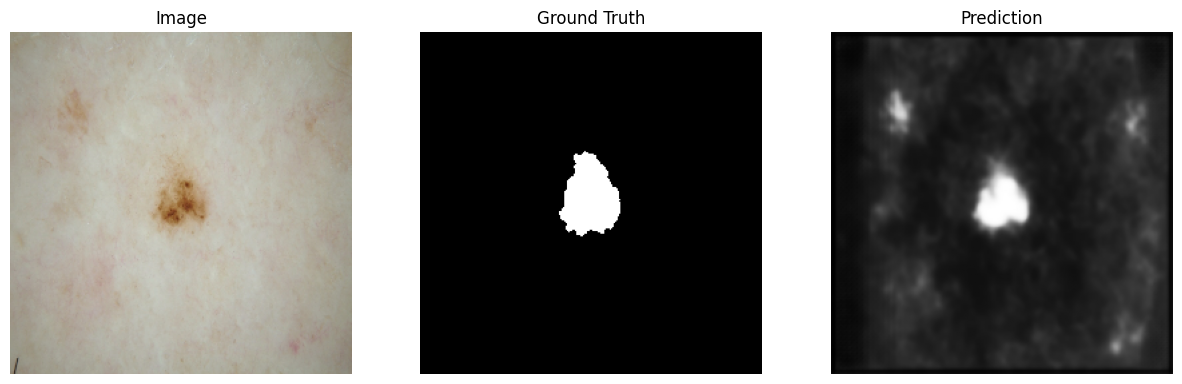

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def display_sample(image, mask, pred_mask):
    image = np.array(image)
    mask = np.array(mask)
    pred_mask = np.array(pred_mask)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(mask[:, :, 0], cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    plt.imshow(pred_mask[:, :, 0], cmap='gray')
    plt.axis('off')

    plt.show()

# Predict and visualize one sample from training data
for image_batch, mask_batch in train_dataset.take(1):
    pred_mask = model.predict(image_batch)
    display_sample(
        image_batch[0].numpy(),
        mask_batch[0].numpy(),
        pred_mask[0]
    )


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


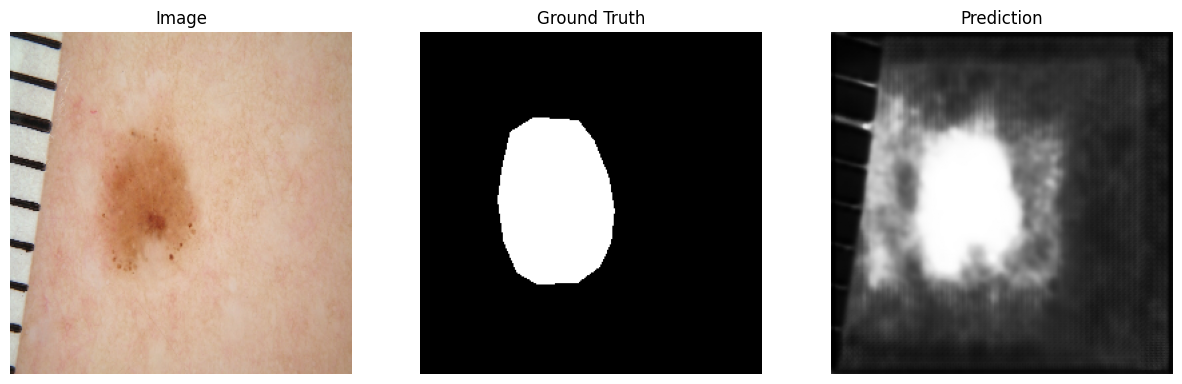

In [ ]:
# Pick any image from your dataset (e.g., second batch)
for image_batch, mask_batch in train_dataset.skip(1).take(1):  # skip(1) → get 2nd batch
    pred_mask = model.predict(image_batch)
    display_sample(
        image_batch[0].numpy(),
        mask_batch[0].numpy(),
        pred_mask[0]
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


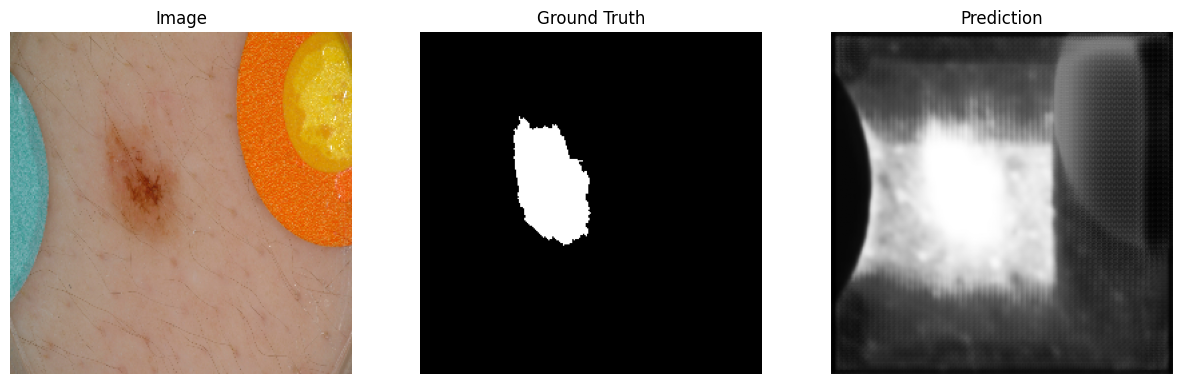

In [ ]:
for image_batch, mask_batch in train_dataset.skip(4).take(1):
    pred_mask = model.predict(image_batch)
    display_sample(
        image_batch[2].numpy(),
        mask_batch[2].numpy(),
        pred_mask[2]
    )
